In [1]:
%autosave 60

Autosaving every 60 seconds


In [2]:
BUCKET_NAME = "msil_raw"
FOLDER_NAME = "training_data"
FILE_NAME = "ml_data_unsorted.csv"

In [3]:
import google.datalab.storage as storage
import pandas as pd
from io import BytesIO

In [4]:
# importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import time
from datetime import datetime
from scipy import integrate

/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
mybucket = storage.Bucket(BUCKET_NAME)
data_csv = mybucket.object(FOLDER_NAME + "/" + FILE_NAME)

uri = data_csv.uri
%gcs read --object $uri --variable data

data = pd.read_csv(BytesIO(data))
data.head()

,IMEI,Year,Month,Day,Hour,Minute,Seconds,sp,EVVSP,EVGPO,...,EVIRT_Min,EVDI2,EVBMI_Latest,EVBMA_Latest,EVVAC,EVODO,EVODOH,EVSMA_EWMA,EVSMA_delta,combined
0,3.582721e+14,2018,11,15,10,58,49,0.0,0.0,10,...,-41,20,21.5,21.5,0.0,690,0.0,93.2,0.0,1617
1,3.582721e+14,2018,11,15,10,58,50,1000.0,0.0,10,...,-41,20,21.5,21.5,0.0,690,0.0,93.2,0.0,1617
2,3.582721e+14,2018,11,15,10,58,51,2000.0,0.0,10,...,-41,20,21.5,21.5,0.0,690,0.0,93.2,0.0,1617
3,3.582721e+14,2018,11,15,10,58,52,3000.0,0.0,10,...,-41,20,21.5,21.5,0.0,690,0.0,93.2,0.0,1617
4,3.582721e+14,2018,11,15,10,58,53,4000.0,0.0,10,...,-41,20,21.5,21.5,0.0,690,0.0,93.2,0.0,1617


In [6]:
# setting up the parameters
plt.rcParams["figure.figsize"] = (10, 10)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("precision", 15)
sns.set_style("darkgrid")

In [7]:
data.head()

,IMEI,Year,Month,Day,Hour,Minute,Seconds,sp,EVVSP,EVGPO,EVOAS,EVIGM_Latest,EVCOM_Latest,EVIRT_Min,EVDI2,EVBMI_Latest,EVBMA_Latest,EVVAC,EVODO,EVODOH,EVSMA_EWMA,EVSMA_delta,combined
0,358272088716215.0,2018,11,15,10,58,49,0.0,0.0,10,26.0,-51,-51,-41,20,21.5,21.5,0.0,690,0.0,93.200000000000003,0.0,1617
1,358272088716215.0,2018,11,15,10,58,50,1000.0,0.0,10,26.0,-51,-51,-41,20,21.5,21.5,0.0,690,0.0,93.200000000000003,0.0,1617
2,358272088716215.0,2018,11,15,10,58,51,2000.0,0.0,10,26.0,-51,-51,-41,20,21.5,21.5,0.0,690,0.0,93.200000000000003,0.0,1617
3,358272088716215.0,2018,11,15,10,58,52,3000.0,0.0,10,26.0,-51,-51,-41,20,21.5,21.5,0.0,690,0.0,93.200000000000003,0.0,1617
4,358272088716215.0,2018,11,15,10,58,53,4000.0,0.0,10,26.0,-51,-51,-41,20,21.5,21.5,0.0,690,0.0,93.200000000000003,0.0,1617


In [8]:
# replacing the EVGPO values
data["EVGPO"] = data["EVGPO"].map({
  10: "E",
  8: "E",
  9: "E",
  -1: "E",
  1: "B"
})

In [9]:
data["EVGPO"] = data["EVGPO"].fillna("E")

In [10]:
data["EVGPO"] = data["EVGPO"].map({
  "E": 0,
  "B": 1
})

In [11]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [12]:
data["IMEI"] = encoder.fit_transform(data["IMEI"])

In [13]:
data.head()

,IMEI,Year,Month,Day,Hour,Minute,Seconds,sp,EVVSP,EVGPO,EVOAS,EVIGM_Latest,EVCOM_Latest,EVIRT_Min,EVDI2,EVBMI_Latest,EVBMA_Latest,EVVAC,EVODO,EVODOH,EVSMA_EWMA,EVSMA_delta,combined
0,7,2018,11,15,10,58,49,0.0,0.0,0,26.0,-51,-51,-41,20,21.5,21.5,0.0,690,0.0,93.200000000000003,0.0,1617
1,7,2018,11,15,10,58,50,1000.0,0.0,0,26.0,-51,-51,-41,20,21.5,21.5,0.0,690,0.0,93.200000000000003,0.0,1617
2,7,2018,11,15,10,58,51,2000.0,0.0,0,26.0,-51,-51,-41,20,21.5,21.5,0.0,690,0.0,93.200000000000003,0.0,1617
3,7,2018,11,15,10,58,52,3000.0,0.0,0,26.0,-51,-51,-41,20,21.5,21.5,0.0,690,0.0,93.200000000000003,0.0,1617
4,7,2018,11,15,10,58,53,4000.0,0.0,0,26.0,-51,-51,-41,20,21.5,21.5,0.0,690,0.0,93.200000000000003,0.0,1617


In [14]:
#data = data.drop(columns = ["Year", "Month", "Day", "Hour", "Minute", "Seconds"])

In [15]:
data.head()

,IMEI,Year,Month,Day,Hour,Minute,Seconds,sp,EVVSP,EVGPO,EVOAS,EVIGM_Latest,EVCOM_Latest,EVIRT_Min,EVDI2,EVBMI_Latest,EVBMA_Latest,EVVAC,EVODO,EVODOH,EVSMA_EWMA,EVSMA_delta,combined
0,7,2018,11,15,10,58,49,0.0,0.0,0,26.0,-51,-51,-41,20,21.5,21.5,0.0,690,0.0,93.200000000000003,0.0,1617
1,7,2018,11,15,10,58,50,1000.0,0.0,0,26.0,-51,-51,-41,20,21.5,21.5,0.0,690,0.0,93.200000000000003,0.0,1617
2,7,2018,11,15,10,58,51,2000.0,0.0,0,26.0,-51,-51,-41,20,21.5,21.5,0.0,690,0.0,93.200000000000003,0.0,1617
3,7,2018,11,15,10,58,52,3000.0,0.0,0,26.0,-51,-51,-41,20,21.5,21.5,0.0,690,0.0,93.200000000000003,0.0,1617
4,7,2018,11,15,10,58,53,4000.0,0.0,0,26.0,-51,-51,-41,20,21.5,21.5,0.0,690,0.0,93.200000000000003,0.0,1617


---
## Train Test Split

In [16]:
# dropping the EVSMA_EWMA column as we will train against the EVSMA_delta value
df = data.drop(columns = ["EVSMA_EWMA"])

In [17]:
# scaling the EVSMA_delta value so that it's values become more significant
df["EVSMA_delta"] = df["EVSMA_delta"]

In [18]:
df.head()

,IMEI,Year,Month,Day,Hour,Minute,Seconds,sp,EVVSP,EVGPO,EVOAS,EVIGM_Latest,EVCOM_Latest,EVIRT_Min,EVDI2,EVBMI_Latest,EVBMA_Latest,EVVAC,EVODO,EVODOH,EVSMA_delta,combined
0,7,2018,11,15,10,58,49,0.0,0.0,0,26.0,-51,-51,-41,20,21.5,21.5,0.0,690,0.0,0.0,1617
1,7,2018,11,15,10,58,50,1000.0,0.0,0,26.0,-51,-51,-41,20,21.5,21.5,0.0,690,0.0,0.0,1617
2,7,2018,11,15,10,58,51,2000.0,0.0,0,26.0,-51,-51,-41,20,21.5,21.5,0.0,690,0.0,0.0,1617
3,7,2018,11,15,10,58,52,3000.0,0.0,0,26.0,-51,-51,-41,20,21.5,21.5,0.0,690,0.0,0.0,1617
4,7,2018,11,15,10,58,53,4000.0,0.0,0,26.0,-51,-51,-41,20,21.5,21.5,0.0,690,0.0,0.0,1617


In [19]:
# bisecting the training data
train = df[df["combined"]<1400].reset_index(drop = True)

In [20]:
len(train[train["EVGPO"] == 1])

6103

In [21]:
valid = df[df["combined"].between(1400, 1500, inclusive = False)].reset_index(drop = True)

In [22]:
len(valid[valid["EVGPO"] == 1])

551

In [23]:
test = df[df["combined"]>1500].reset_index(drop = True)

In [24]:
len(test[test["EVGPO"] == 1])

14339

In [25]:
print("Train = {}".format(len(train)))
print("Valid = {}".format(len(valid)))
print("Test = {}".format(len(test)))

Train = 3181967
Valid = 210300
Test = 673059


In [26]:
# trainset and testset
x_train = train.drop(columns = ["EVSMA_delta"])
y_train = train["EVSMA_delta"]

x_valid = valid.drop(columns = ["EVSMA_delta"])
y_valid = valid["EVSMA_delta"]

x_test = test.drop(columns = ["EVSMA_delta"])
y_test = test["EVSMA_delta"]

In [27]:
x_train.head()

,IMEI,Year,Month,Day,Hour,Minute,Seconds,sp,EVVSP,EVGPO,EVOAS,EVIGM_Latest,EVCOM_Latest,EVIRT_Min,EVDI2,EVBMI_Latest,EVBMA_Latest,EVVAC,EVODO,EVODOH,combined
0,4,2018,11,15,7,9,39,0.0,53.250000000000000,0,20.0,25,38,213,22,21.5,22.5,0.000000000000000,806,0.000000000000000,1272
1,4,2018,11,15,7,9,40,1000.0,51.492199999999997,0,20.0,25,38,19,22,21.5,22.5,-4.882777777777787,806,0.014547527777778,1272
2,4,2018,11,15,7,9,41,2000.0,50.367199999999997,0,20.0,24,38,19,22,21.5,22.5,-3.125000000000000,806,0.028694666666667,1272
3,4,2018,11,15,7,9,42,3000.0,48.804699999999997,0,20.0,25,38,19,22,21.5,22.5,-4.340277777777779,806,0.042468541666667,1272
4,4,2018,11,15,7,9,43,4000.0,47.101599999999998,0,20.0,25,38,19,22,21.5,22.5,-4.730833333333331,806,0.055788861111111,1272


In [28]:
y_train.sample(5)

540555     0.007488342965104
2939880    0.005918603426124
2507368    0.007896753173270
2683830    0.004134597551939
741093     0.007214213297274
Name: EVSMA_delta, dtype: float64

In [29]:
# defining the parameters
params = {
    "eta":0.01,
    "n_estimators": 100,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 1,
    "gamma": 0,
    "eval_metric": "rmse",
    "nthreads": 4,
    "objective": "reg:linear"
    
}

In [30]:
# converting the datasets into DMatrix, a format required by XGBoost
dtrain = xgb.DMatrix(x_train, label = y_train)
dvalid = xgb.DMatrix(x_valid, label = y_valid)

In [ ]:
# training the Model
model_train = xgb.train(params, dtrain, 5000, evals = [(dvalid, "valid_set")], verbose_eval=1000)

[0]	valid_set-rmse:0.489406
[1000]	valid_set-rmse:0.005179
[2000]	valid_set-rmse:0.005015
[3000]	valid_set-rmse:0.004756


- The error is continuously increasing because the training dataset is not representative of validation dataset. We can try GridSearch and Shuffling the dataset. 

In [ ]:
# testset DMatrix
dtest = xgb.DMatrix(x_test)

In [ ]:
#predictions
y_pred = model_train.predict(dtest)

In [ ]:
y_pred

In [ ]:
# making a dataframe of actual and predicted values
result_df = pd.DataFrame({
    "y": y_test,
    "yhat": y_pred
})

In [ ]:
err = (((result_df["y"] - result_df["yhat"])**2).mean())**0.5
print("Error on First XGB Iteration = {}".format(err))

In [ ]:
plt.plot(list(y_test)[300000:340000])
plt.plot(y_pred[300000:340000])
plt.show()

---
## Grid Search CV (Hyperparameter Tuning)

In [46]:
# cross-validation results
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round = 50,
    seed = 42,
    nfold = 10,
    metrics = "rmse",
    early_stopping_rounds = 10
)

In [47]:
cv_results.min()

test-rmse-mean     0.298982100000000
test-rmse-std      0.000004867237409
train-rmse-mean    0.298982100000000
train-rmse-std     0.000000458257569
dtype: float64

In [49]:
import pickle
# save model to file
pickle.dump(model_train, open("pima.pickle.dat", "wb"))

In [2]:
import pickle
model_train=pickle.load(open('pima.pickle.dat','rb'))

/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [31]:
# defining gridsearch parameters
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(3, 12)
    for min_child_weight in range(1, 8)
]

In [ ]:
# running the loop which will give us best paramters based on RMSE
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("max_depth = {} ... min_child_weight = {}".format(max_depth, min_child_weight))
    params["max_depth"] = max_depth
    params["min_child_weight"] = min_child_weight
    
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round = 50,
        seed = 42,
        nfold = 10,
        metrics = "rmse",
        early_stopping_rounds = 10
    )
    mean_rmse = cv_results["test-rmse-mean"].min()
    boost_rounds = cv_results["test-rmse-mean"].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth, min_child_weight)
        
print("Best params: {} ... {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

max_depth = 3 ... min_child_weight = 1


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:19: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


	RMSE 0.2989828 for 49 rounds
max_depth = 3 ... min_child_weight = 2
	RMSE 0.2989828 for 49 rounds
max_depth = 3 ... min_child_weight = 3
	RMSE 0.2989828 for 49 rounds
max_depth = 3 ... min_child_weight = 4
	RMSE 0.2989828 for 49 rounds
max_depth = 3 ... min_child_weight = 5
	RMSE 0.2989828 for 49 rounds
max_depth = 3 ... min_child_weight = 6
	RMSE 0.2989828 for 49 rounds
max_depth = 3 ... min_child_weight = 7
	RMSE 0.2989828 for 49 rounds
max_depth = 4 ... min_child_weight = 1
	RMSE 0.2989824 for 49 rounds
max_depth = 4 ... min_child_weight = 2
	RMSE 0.2989824 for 49 rounds
max_depth = 4 ... min_child_weight = 3
	RMSE 0.2989824 for 49 rounds
max_depth = 4 ... min_child_weight = 4
	RMSE 0.2989824 for 49 rounds
max_depth = 4 ... min_child_weight = 5
	RMSE 0.2989824 for 49 rounds
max_depth = 4 ... min_child_weight = 6
	RMSE 0.2989824 for 49 rounds
max_depth = 4 ... min_child_weight = 7
	RMSE 0.2989824 for 49 rounds
max_depth = 5 ... min_child_weight = 1
	RMSE 0.29898210000000003 for 49 r

In [100]:
# repeating the exercise for other parameters
gridsearch_params_2 = [
    (colsample_bytree, eta)
    for colsample_bytree in [0,1]
    for eta in [0.01, 0.1, 0.05, 0.5, 0.02]
]

In [102]:
min_rmse = float("Inf")
best_params = None
for colsample_bytree, eta in gridsearch_params_2:
    print("colsample_bytree = {} ... eta = {}".format(colsample_bytree, eta))
    params["colsample_bytree"] = colsample_bytree
    params["eta"] = eta
    
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round = 50,
        seed = 42,
        nfold = 10,
        metrics = "rmse",
        early_stopping_rounds = 10
    )
    mean_rmse = cv_results["test-rmse-mean"].min()
    boost_rounds = cv_results["test-rmse-mean"].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (colsample_bytree, eta)
        
print("Best params: {} ... {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

colsample_bytree = 0 ... eta = 0.01


/home/CWSHPMU2316/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


	RMSE 62.2949379 for 49 rounds
colsample_bytree = 0 ... eta = 0.1
	RMSE 42.31141269999999 for 49 rounds
colsample_bytree = 0 ... eta = 0.05
	RMSE 46.495300300000004 for 49 rounds
colsample_bytree = 0 ... eta = 0.5
	RMSE 34.0495374 for 49 rounds
colsample_bytree = 0 ... eta = 0.02
	RMSE 54.4575021 for 49 rounds
colsample_bytree = 1 ... eta = 0.01
	RMSE 51.469814400000004 for 49 rounds
colsample_bytree = 1 ... eta = 0.1
	RMSE 8.7462114 for 49 rounds
colsample_bytree = 1 ... eta = 0.05
	RMSE 17.1712455 for 49 rounds
colsample_bytree = 1 ... eta = 0.5
	RMSE 3.9894693999999995 for 49 rounds
colsample_bytree = 1 ... eta = 0.02
	RMSE 35.7519722 for 49 rounds
Best params: 1 ... 0.5, RMSE: 3.9894693999999995


In [103]:
gridsearch_params_3 = [
    (n_estimators, gamma)
    for n_estimators in [80, 100, 150]
    for gamma in [0, 1, 2]
]

In [105]:
min_rmse = float("Inf")
best_params = None
for n_estimators, gamma in gridsearch_params_3:
    print("n_estimators = {} ... gamma = {}".format(n_estimators, gamma))
    params["n_estimators"] = n_estimators
    params["gamma"] = gamma
    
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round = 50,
        seed = 42,
        nfold = 10,
        metrics = "rmse",
        early_stopping_rounds = 10
    )
    mean_rmse = cv_results["test-rmse-mean"].min()
    boost_rounds = cv_results["test-rmse-mean"].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (n_estimators, gamma)
        
print("Best params: {} ... {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

n_estimators = 80 ... gamma = 0


/home/CWSHPMU2316/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


	RMSE 35.7519722 for 49 rounds
n_estimators = 80 ... gamma = 1
	RMSE 35.7520839 for 49 rounds
n_estimators = 80 ... gamma = 2
	RMSE 35.75173650000001 for 49 rounds
n_estimators = 100 ... gamma = 0
	RMSE 35.751973 for 49 rounds
n_estimators = 100 ... gamma = 1
	RMSE 35.7520833 for 49 rounds
n_estimators = 100 ... gamma = 2
	RMSE 35.7517361 for 49 rounds
n_estimators = 150 ... gamma = 0
	RMSE 35.7519726 for 49 rounds
n_estimators = 150 ... gamma = 1
	RMSE 35.752084 for 49 rounds
n_estimators = 150 ... gamma = 2
	RMSE 35.7517349 for 49 rounds
Best params: 150 ... 2, RMSE: 35.7517349


---

## Training the model after First attempt at Grid Search

In [106]:
# defining the parameters
params = {
    "eta":0.5,
    "n_estimators": 150,
    "max_depth": 11,
    "min_child_weight": 3,
    "subsample": 0.8,
    "colsample_bytree": 1,
    "gamma": 2,
    "eval_metric": "rmse",
    "nthreads": 4,
    "objective": "reg:linear"
    
}

In [122]:
model_train = xgb.train(params, dtrain, 1000, evals = [(dvalid, "valid_set")], verbose_eval=500)

[0]	valid_set-rmse:41.9028
[500]	valid_set-rmse:57.6829
[999]	valid_set-rmse:57.6601


In [123]:
dtest = xgb.DMatrix(x_test)

In [124]:
#predictions
y_pred = model_train.predict(dtest)

In [125]:
# making a dataframe of actual and predicted values
result_df = pd.DataFrame({
    "y": y_test,
    "yhat": y_pred
})

In [126]:
err = (((result_df["y"] - result_df["yhat"])**2).mean())**0.5
print("Error on Second XGB Iteration = {}".format(err))

Error on Second XGB Iteration = 61.67323389123271


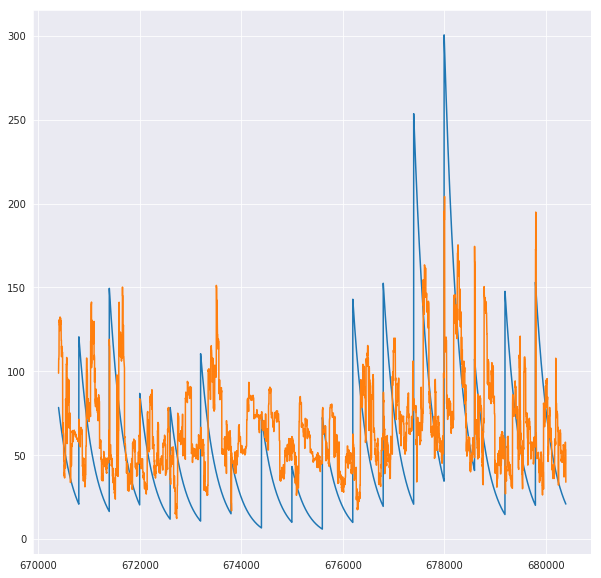

In [129]:
plt.plot(result_df["y"][20000:30000])
plt.plot(result_df["yhat"][20000:30000])
plt.show()

In [128]:
result_df.sample(20)

,y,yhat
704923,19.420529,53.211880
746296,28.528889,37.800877
748421,137.985993,129.132645
712348,47.099433,58.987907
681412,44.831394,54.950222
675906,25.932843,33.093369
773734,27.083569,225.085297
724214,76.701543,100.376053
698239,29.513517,52.610680
748481,112.973355,105.865540


---

## CONCLUSION OF NOTEBOOK
From the first and second iteration, we don't see any improvements.

| ITERATION | RMSE |
------------|------
| First     | 61.33|
| Second    | 61.80|

But, after Grid Search, our model is learning the pattern better. So, that is something we can work on from here on.

### Steps to be taken into consideration - 
- Use more dataset
- Shuffling should be done
- Use Feature Engineering and windowing functions